<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Natural Language Processing For Everyone</h1>
        <h1>Topic Modeling</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import string
from collections import Counter
from pprint import pprint
import gzip
import matplotlib.pyplot as plt 
import numpy as np
from numpy.linalg import svd
from numpy import diag

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

watermark 2.0.2
json      2.0.9
autopep8  1.5
numpy     1.18.1
Mon Sep 14 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 2746551f5f81e82704a3a31f15d48dc15b562707


Set the default style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Preprocessing

Load a standard list of stopwords from a file

In [4]:
stopwords = set([word.lower().strip() for word in open("data/nltk_stopwords.txt", "rt").readlines()])

In [5]:
list(stopwords)[:10]

['below',
 'himself',
 'll',
 'd',
 "that'll",
 'more',
 'not',
 'couldn',
 'same',
 'between']

Define a function to extract the words from our input file. Here we have to be (slightly) more careful than in the previous lesson since we want to keep #tags and @mentions and remove stopwords.

In [6]:
def extract_words(text, stopwords):
    temp = text.split() # Split the text on whitespace
    text_words = []

    punctuation = set(string.punctuation)
    
    #Keep #tags and @mentions
    punctuation.remove("#")
    punctuation.remove("@")
    
    for word in temp:
        # Remove any punctuation characters present in the beginning of the word
        while len(word) > 0 and word[0] in punctuation:
            word = word[1:]

        # Remove any punctuation characters present in the end of the word
        while len(word) > 0 and word[-1] in punctuation:
            word = word[:-1]

        # Simple rule to eliminate (most) URLs "http://www.google.com"
        if len(word) > 0 and "/" not in word:
            # If it's not a stopword
            if word.lower() not in stopwords:
                # Append this word into our list of words.
                text_words.append(word.lower())
        
    return text_words

Process the data from the file. File was obtained from crowdflower (https://www.crowdflower.com/data-for-everyone/) and contains a list of tweets about Apple from 2014 and some information about their sentiment. For our purposes, we only care about the text of each tweet that is located in the last column of the csv file.

We treat each tweet as an individual document, and limit ourselves to only the first 200 tweets.

In [7]:
tweets = []
line_count = 0

for line in open("data/Apple-Twitter-Sentiment-DFE.csv", "rt"):
    fields = line.strip().split(',')
    
    line_count += 1
    
    # Skip the first line of the file which contains the header
    if line_count == 1:
        continue
    
    text = ",".join(fields[11:])
    
    if len(text) == 0:
        continue
    
    words = extract_words(text, stopwords)
    
    if len(words) > 0:
        tweets.append(words)
        
    if len(tweets) == 200:
        break

In [8]:
tweets[:2]

[['cat', 'chews', '@apple', 'cords', '#applesnob'],
 ['nobody', 'expects', 'spanish', 'inquisition', '#aapl']]

Define the function to calculate the Inverse Document Frequency for each word and the TFIDF matrix. These functions were introduced in the previous lesson.

In [9]:
def inv_doc_freq(corpus_words):
    number_docs = len(corpus_words)
    
    document_count = {}

    for document in corpus_words:
        word_set = set(document)

        for word in word_set:
            document_count[word] = document_count.get(word, 0) + 1
    
    IDF = {}
    
    for word in document_count:
        IDF[word] = np.log(number_docs/document_count[word])
        
    
    return IDF

def tf_idf(corpus_words):
    IDF = inv_doc_freq(corpus_words)
    
    TFIDF = []
    
    for document in corpus_words:
        TFIDF.append(Counter(document))
    
    for document in TFIDF:
        for word in document:
            document[word] = document[word]*IDF[word]
            
    return TFIDF

Get the TFIDF matrix for our corpus of tweets. We should note that while we call it a matrix, this is effectively a list of dictionaries, which we can consider to be a sparse representation of a matrix.

In [10]:
TFIDF = tf_idf(tweets)

In [11]:
TFIDF[:3]

[Counter({'#applesnob': 5.298317366548036,
          '@apple': 0.2169130015635736,
          'cat': 5.298317366548036,
          'chews': 5.298317366548036,
          'cords': 5.298317366548036}),
 Counter({'#aapl': 1.9310215365615626,
          'expects': 5.298317366548036,
          'inquisition': 5.298317366548036,
          'nobody': 5.298317366548036,
          'spanish': 5.298317366548036}),
 Counter({'#aapl:5': 5.298317366548036,
          'apple': 2.5902671654458267,
          'buy': 3.506557897319982,
          'december': 4.605170185988092,
          'gains': 5.298317366548036,
          'rocket': 5.298317366548036,
          'stocks': 5.298317366548036})]

For convenience, extract the word_dict and word_list from the TFIDF matrix.

In [12]:
def build_vocabulary(TFIDF):
    words = set()
    
    for document in TFIDF:
        words |= set(document.keys())
    
    word_list = list(words)
    word_dict = dict(zip(word_list, range(len(word_list))))
    
    return word_dict, word_list

In [13]:
word_dict, word_list = build_vocabulary(TFIDF)

In [14]:
vocabulary_size = len(word_dict)
print("We have", vocabulary_size, "words in our vocabulary")

We have 927 words in our vocabulary


In [15]:
word_list[:10]

['powers',
 'york',
 '#recent',
 'chart',
 'boot',
 'buying',
 'amendment',
 "that's",
 'people',
 '#iphone']

Now use the TFIDF matrix and our vocabulary to generate the Term Document matrix. This is just a matter of rearranging the values in our (sparse) TFIDF matrix into the full TD matrix.

In [16]:
def term_document_matrix(TFIDF, word_list, word_dict):
    vocabulary_size = len(word_dict)
    number_documents = len(TFIDF)
    
    TDM = np.zeros((vocabulary_size, number_documents))
    
    for doc in range(number_documents):
        document = TFIDF[doc]
        
        for word in document.keys():
            pos = word_dict[word]
            
            TDM[pos, doc] = document[word]
            
    return TDM

In [17]:
TDM = term_document_matrix(TFIDF, word_list, word_dict)
print("Our dataset has:\n%u unique words\n%u documents"%(TDM.shape))

Our dataset has:
927 unique words
200 documents


In [18]:
TDM.shape

(927, 200)

## Explicit Semantic Analysis

In ESA we use the TD matrix of our corpus as a knowledge base that we can use to look up related documents. To demonstrate how this works, let's create a new document:

In [19]:
new_tweet = ['#macbook', 'mini', 'rocket']

This is not an actual sentence since, for clarity, we are not including stopwords.

In the TD formulation, the values in the word (row) vector representa how much each document is "activated" by that specific word. Naturally, documents in which the word does not appear have weight zero. We can use these word vectors to find a vector representation of our new document where each value is our related it is to every other document in our knowledge base. You can think of this as the set of results one might obtain after a query in a search engine!

The **find_related** simply calcuates the vector corresponding to the new "document" and returns a list of the corresponding weights sorted in decreasing order:

In [20]:
def find_related_docs(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
        
    # Now the entries of new_vector tell us which documents are activated by this one.
    # Let's extract the list of documents sorted by activation
    doc_list = sorted(zip(range(TDM.shape[1]), new_vector), key=lambda x:x[1], reverse=True)
    
    return doc_list

In [21]:
related = find_related_docs(new_tweet, TDM)

Let's take a look a the top 5 results:

In [22]:
for tweet, score in related[:5]:
    print(score, tweet, " ".join(tweets[tweet]))

6.607650686531799 166 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
6.607650686531799 167 ipad mini first time startup via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unbox
6.607650686531799 190 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
6.607650686531799 191 ipad mini first time startup via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unbox
5.298317366548036 2 #aapl:5 rocket stocks buy december gains apple


With such small documents, the results are easy to interpret. The first two result are due to mentions of **macbook** and **mini**, the third due to the presence of the word **rocket** but the remaining two results don't include any words in common with our original tweet, just words that appear in similar contexts.

In [23]:
def similarity(vec1, vec2):
    sim = np.dot(vec1, vec2)
    norm1 = np.sqrt(np.dot(vec1, vec1))
    norm2 = np.sqrt(np.dot(vec2, vec2))
    
    return sim/(norm1*norm2)

In [24]:
def find_similar_words(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
    
    sim = [similarity(new_vector, TDM[i, :]) for i in range(TDM.shape[0])]
    
    sim_words = sorted(zip(range(TDM.shape[0]), sim), key=lambda x:x[1], reverse=True)
    
    return sim_words

In [25]:
similar = find_similar_words(new_tweet, TDM)

In [26]:
for word, score in similar[:10]:
    print(word_list[word], score)

#macbook 0.842346298979266
#hipster 0.8273747381258668
@youtube 0.8273747381258668
#startup 0.8273747381258668
mini 0.8227410508913036
#ipadmini 0.7963450852368475
#macbookpro 0.7800563838816592
ipad 0.7617102018231607
via 0.7055875474518816
#ipad 0.6502130393344844


This approach also returns words that are not included in the document but that are used in a similar context, such as #hipster. One might use this extra words (above some finetuned threshold of similarity) to expand our query and retrieve furhter related documents.

## Latent Semantic Analysis

LSA analysis, sometimes refered to as Latent Semantic Indexing, relies on the well known Singular Value Decomposition. Singular Values (and Singular Vectors) can be thought of as being a generalization of the more common eigenvalues (and eigenvectors) for the case of non-square matrices. 

The first step in any LSA analysis is to apply SVD to the Term-Document matrix:

In [27]:
u, sigma, vt = svd(TDM)

The resulting matrices have the expected shapes, except the singular value matrix, **sigma** that is simply a vector. This is an optimization of the numpy function meant to save memory.

In [28]:
m, n = TDM.shape
print(u.shape, sigma.shape, vt.shape)

(927, 927) (200,) (200, 200)


In [29]:
print(m, n)

927 200


We can now reduce the internal dimention of these matrices to, say, 10. 

In [30]:
k = 10

# Convert the vector of singular values into a diagonal matrix
sigma_k = sigma[:k]
Sk = diag(sigma_k)

# Drop the extraneous dimensions in the other two matrices.
uk = u[:,:k]
vtk = vt[:k, :]

In this way, we preserve the most significant (higher sigma values) latent dimensions of the dataset while discarding the rest. The idea is simple, SVD projects the original dataset into an internal space which is a linear combination of the original one. Each dimension in this space can be thought of as an underlying topic in the data. By preserving only the most dominant topics in effect we are simplifying the data and, potentially, removing noise. 

In [31]:
print(uk.shape, Sk.shape, vtk.shape)

(927, 10) (10, 10) (10, 200)


There are no easy ways to determine the number of topics to choose, but a good rule of thumb is to identify kinks in the values of sigma

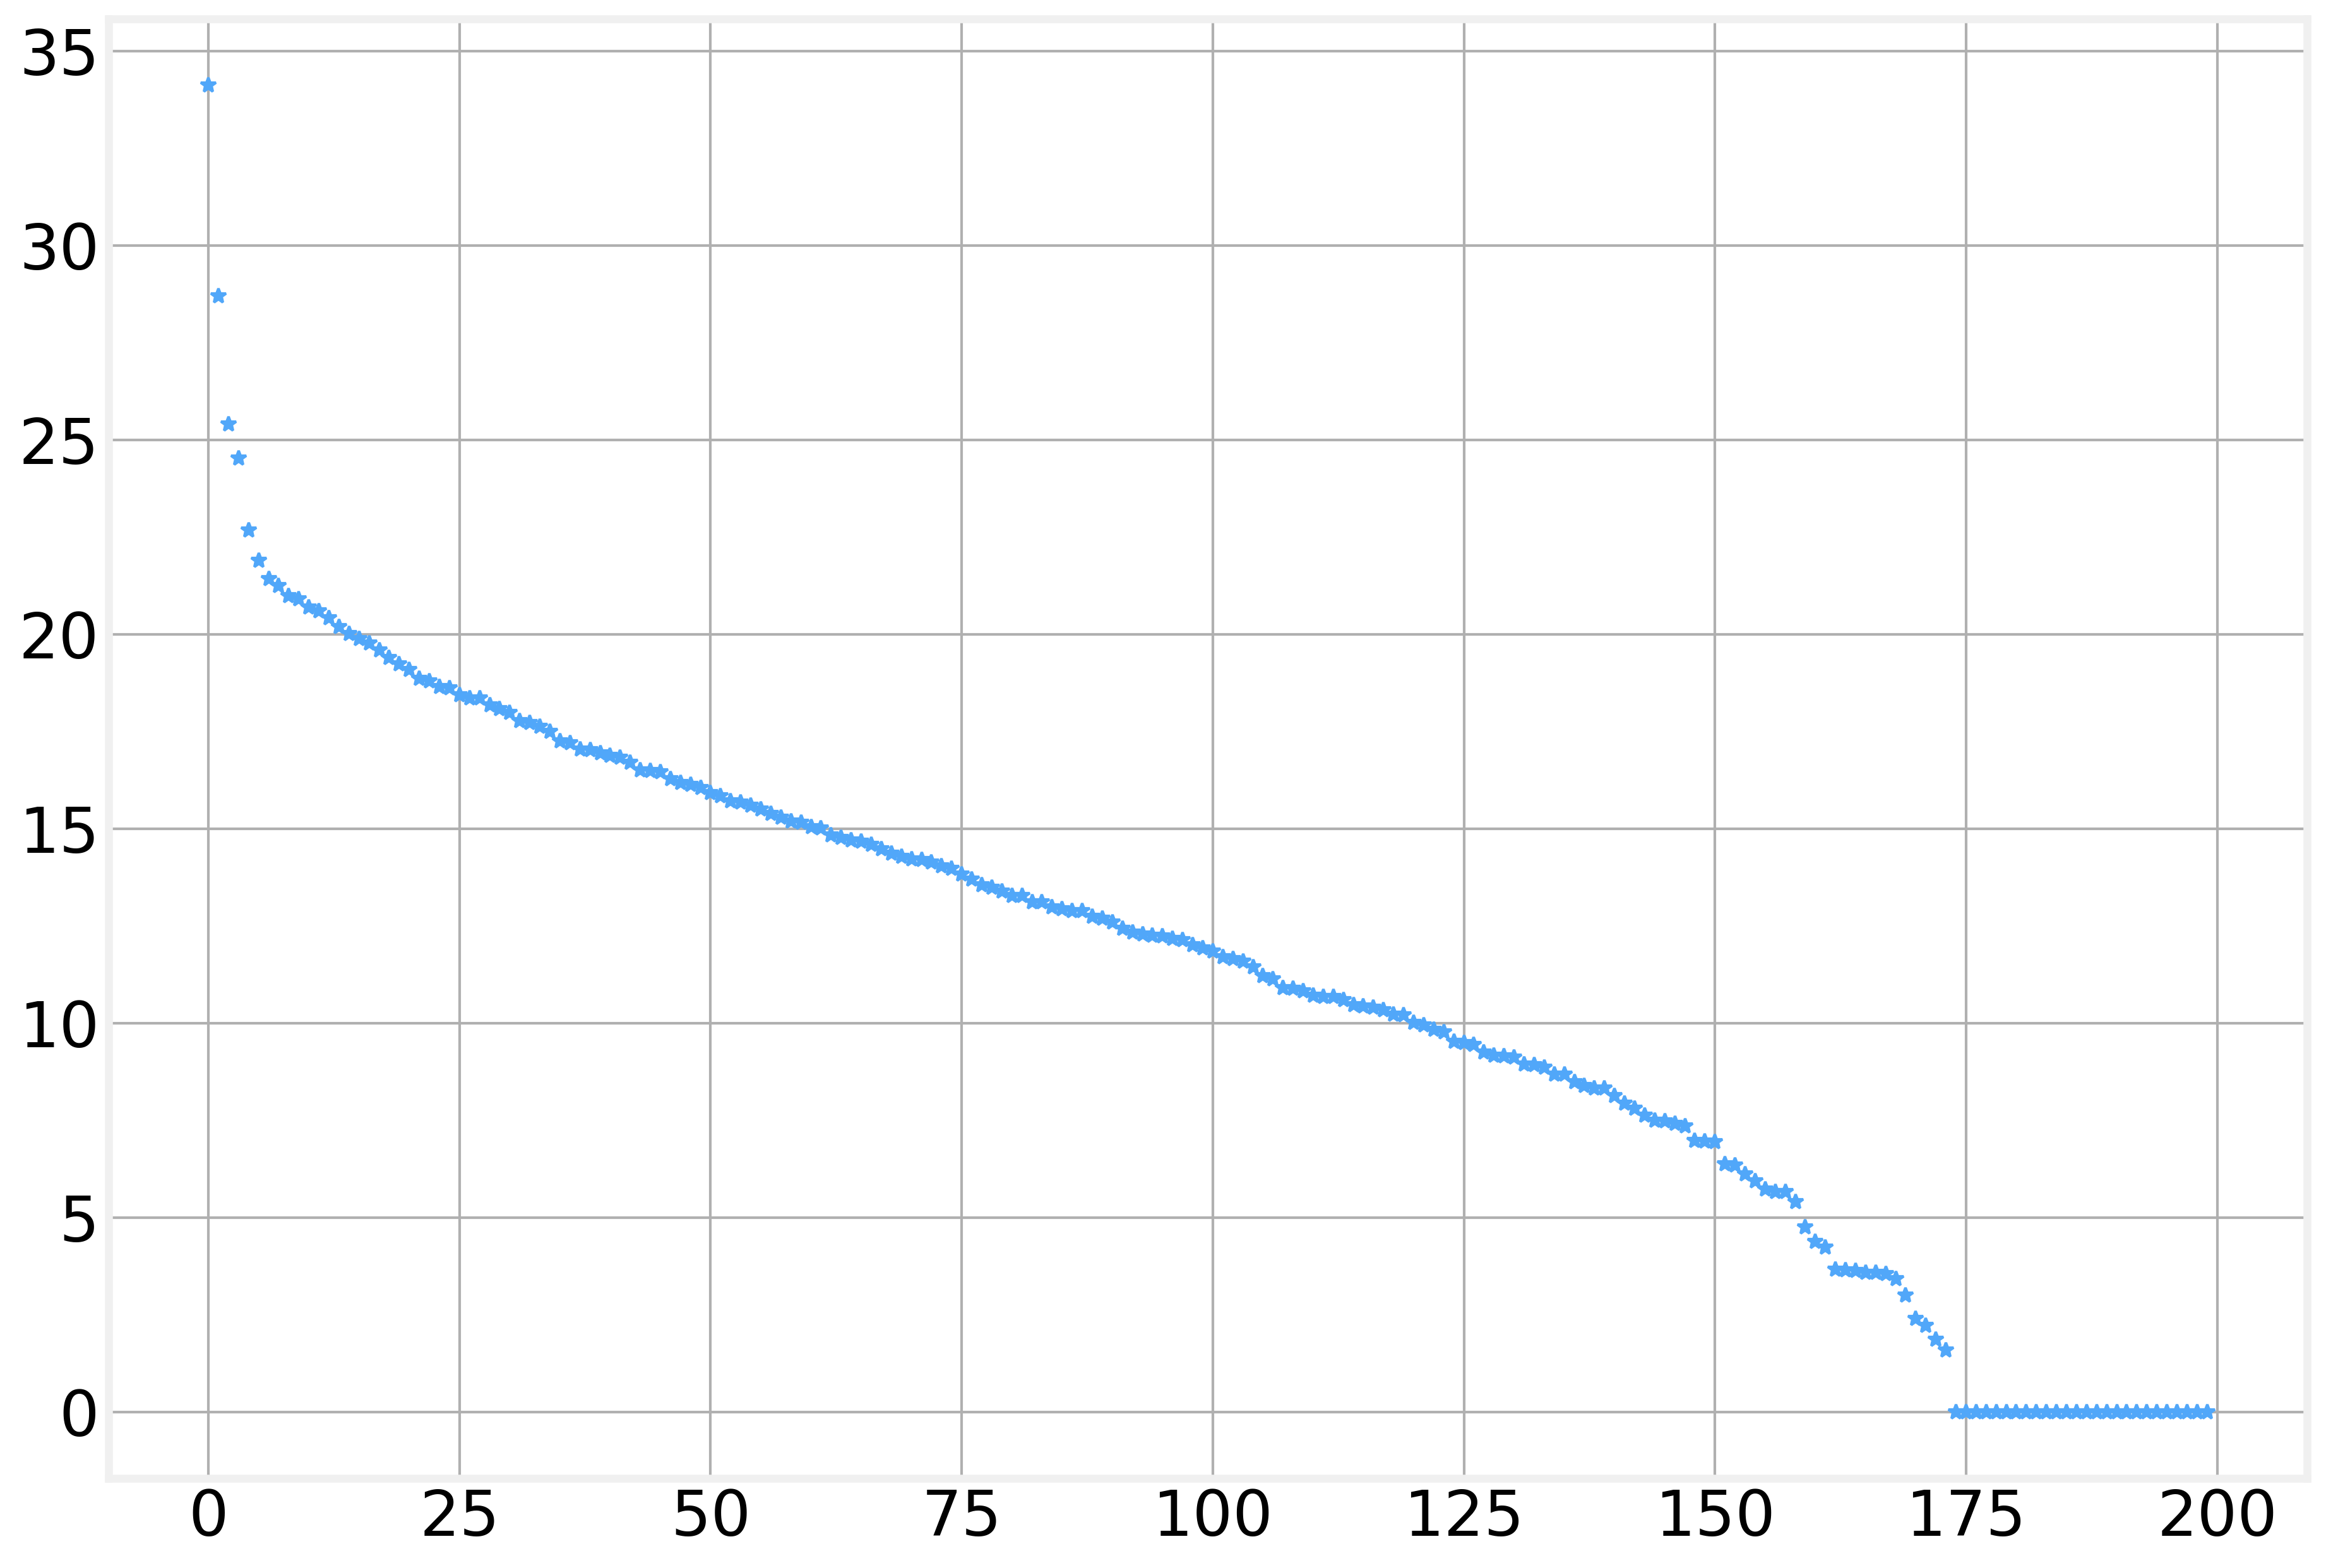

In [32]:
plt.plot(range(200), sigma, '*')

We can also explore the way in which the topics are defined by considering the words for which they have stronger weights:

In [33]:
# Sort the list of words by the weight they have in a specific topic
def top_words(vector, word_list):
    doc_list = sorted(zip(word_list, vector), key=lambda x:x[1], reverse=True)
    
    return doc_list

For example, for topic 3, we have strong mentions of AIDS day and the Produc (RED) iPhone launch:

In [34]:
topic_words = top_words(uk[:,3], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

day 0.28746488014330057
aids 0.2826216409753877
world 0.2692253682039401
red 0.26475561492615646
logo 0.22903406070460355
#apple 0.18504347302677782
apple 0.13868223906604044
abl 0.12638896410764222
dec 0.12638896410764222
launches 0.12638896410764217


On the other hand, if we were trying to map a specific sentence or document into the most relevant topic we would simply have to project it into the singular space. First we define the vector in the "regular" word space:

In [35]:
document = ['ipad', 'mini', 'price']

doc_vector = np.zeros(vocabulary_size)
for word in document:
    doc_vector[word_dict[word]] += 1

and now we project it into the singular space:

In [36]:
doc_singular = 1/sigma_k*np.dot(uk.T, doc_vector)
pprint(doc_singular)

array([ 1.62243400e-04,  1.44900491e-02, -1.09973213e-03,  4.30257980e-05,
        9.69106965e-04, -4.54646796e-03,  7.58613138e-04, -2.40772326e-03,
        3.82599561e-03, -1.95924079e-03])


From where we see that hte most relevant topic is topic number 1:

In [37]:
topic = np.argmax(doc_singular)

print(topic)

topic_words = top_words(uk[:,topic], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

1
#macbook 0.30723559382139015
@youtube 0.30540145699726684
#startup 0.30540145699726673
#hipster 0.3054014569972667
#macbookpro 0.2980960628908025
via 0.2918795721098776
mini 0.20949666233803643
ipad 0.2038176600121253
#ipadmini 0.19891025664321735
startup 0.1932748800761492


Which indeed seems relevant.

## Non-Negative Matrix Factorization

The idea behind applying NMF to a Term-Document Matrix is similar to the goals behind using SVD to perform Latent Semantic Analysis. NMF is a general matrix factorization algorithm and, as such, the factor matrices it finds can also be thought of as internal or latent dimensions. 

Similarly to the case of SVD, we can perform a partial reconstruction of the original matrix by reducing the internal dimensions. Naturally, as the number of latent dimensions increases, the reconstruction error decreases since we are removing less and less information:

In [38]:
def NMF(V, k):
    n, m = V.shape

    W = np.random.rand(n, k)
    H = np.random.rand(k, m)

    error = 1
    err = 1

    while err > 1e-3:
        old_error = error

        hn = np.dot(W.T, V)
        hd = np.dot(W.T, np.dot(W, H))

        H = H*np.divide(hn, hd)

        wn = np.dot(V, H.T)
        wd = np.dot(W, np.dot(H, H.T))

        W = W*np.divide(wn, wd)

        error = np.sum(np.power(V-np.dot(W, H), 2.0))
        err = np.abs(old_error-error)

    return W, H, error

Let's see how the error changes with the number of components.

In [39]:
error = []

for comps in range(2, 25+1):
    W, H, err = NMF(TDM, comps)
    print(comps, err)
    error.append(err)

2 32018.682027744457
3 31373.942968079726
4 30835.315902309783
5 30409.302157133076
6 29821.02337795089
7 29360.333361800775
8 28894.47843266444
9 28464.630632822347
10 28055.56263544962
11 27698.4240208882
12 27209.911674699084
13 26889.016796463704
14 26433.470410179318
15 26017.25854048358
16 25678.18979451143
17 25367.76547377013


/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


18 nan
19 24507.235094574695
20 24172.18159357293
21 23790.316718548533
22 23417.434557622404
23 23265.915794360695
24 22702.40443021297
25 22466.414424116712


The nan values found above are due to numerical instabilities. In practice you should use a well tested numerical library such as sklearn.

Text(0.5, 1.0, 'Non-Negative Matrix Factorization')

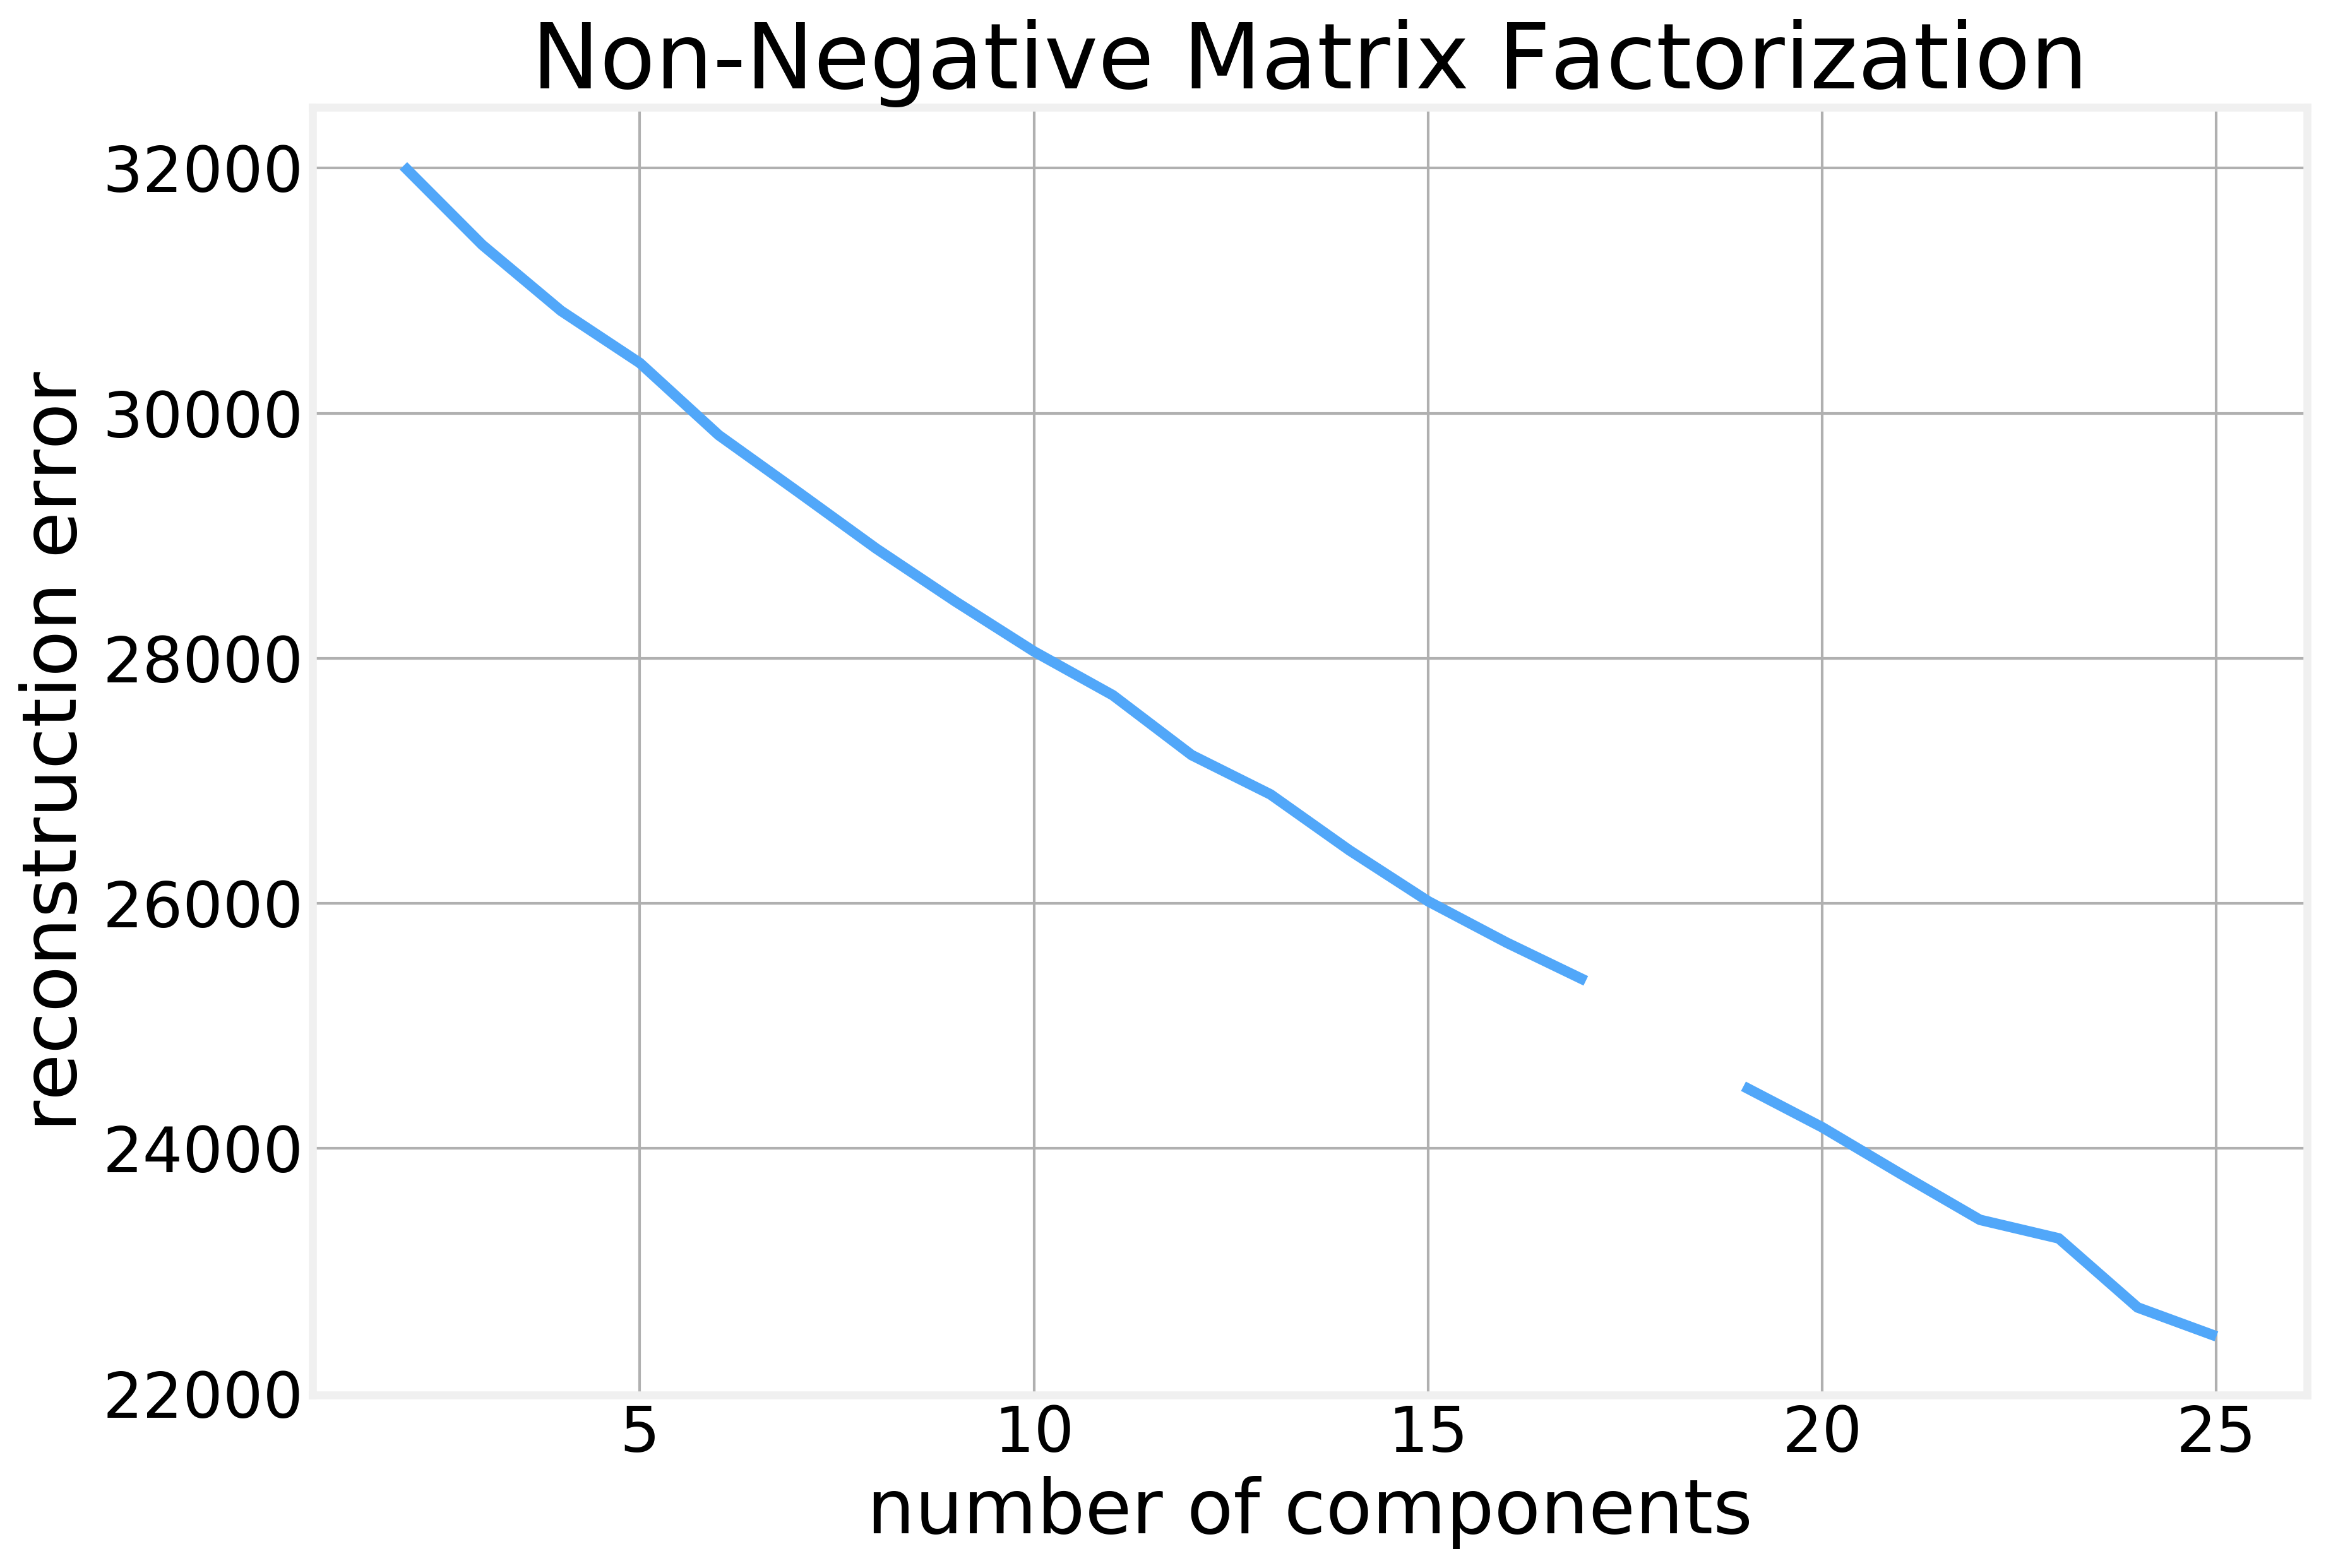

In [40]:
plt.plot(range(2, 25+1), error)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')
plt.title('Non-Negative Matrix Factorization')

For the remainder of this section, lets fix the number of so that we can use these results to illustrate the power of NMF.

In [41]:
W, H, err = NMF(TDM, 10)

When we apply NMF to a Term-Document matrix, as defined above, the resulting factors prove useful for topic detection. In particular, the W matrix provides us with the definition of each topic as a weighted distribution over all the words in the corpus:

Let's look at a couple of examples:

In [42]:
topic_words = top_words(W[:,4], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

#market 14.899029233952366
#recent 14.713704778286651
sold 14.713704778286651
#forex 14.713704778286651
20 14.713704778286651
#nasdaq100 14.713704778286651
#gain 14.713704778286651
#4 14.713704778286651
10.49 14.713704778286651
#exit 14.713704778286651


In [43]:
topic_words = top_words(W[:,9], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

version 24.535882454349068
like 15.671817499585392
buy 12.403599637748563
actually 12.267941227174534
alone 12.267941227174534
#stupid 12.267941227174534
@disney 12.267941227174534
#lame 12.267941227174534
#starwars 12.267941227174534
@itunesmovies 12.267941227174534


<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>